In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

c:\Users\Valmik Belgaonkar\OneDrive\Desktop\MOO-Brain-Tumor-Classification\mooenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 86.8M/86.8M [00:25<00:00, 3.61MB/s]

Extracting files...


Path to dataset files: C:\Users\Valmik Belgaonkar\.cache\kagglehub\datasets\sartajbhuvaji\brain-tumor-classification-mri\versions\2


Without Pareto frontier plotting, currently plotting all trials

[I 2025-04-18 23:24:15,563] A new study created in memory with name: no-name-3cc58795-6f6d-42e1-bcf6-86abd2b83ba5


[I 2025-04-18 23:25:06,816] Trial 0 finished with values: [-0.7833061321281106, -0.7756656804733728, 0.05052264808362361, -0.7839721254355401] and parameters: {'hidden_dim': 8, 'lr': 0.006557620777577005, 'batch_size': 16}.
[I 2025-04-18 23:26:14,467] Trial 1 finished with values: [-0.6464529160964312, -0.6435851063172018, 0.06794425087108014, -0.662020905923345] and parameters: {'hidden_dim': 32, 'lr': 1.701720289817281e-05, 'batch_size': 16}.
[I 2025-04-18 23:27:05,640] Trial 2 finished with values: [-0.8251535559738659, -0.8262269103291906, 0.05400696864111487, -0.818815331010453] and parameters: {'hidden_dim': 16, 'lr': 0.005010757597774418, 'batch_size': 16}.
[I 2025-04-18 23:28:04,423] Trial 3 finished with values: [-0.8138065199780801, -0.7825396267814049, 0.09407665505226492, -0.789198606271777] and parameters: {'hidden_dim': 16, 'lr': 0.0006810412835298081, 'batch_size': 8}.
[I 2025-04-18 23:29:13,305] Trial 4 finished with values: [-0.8344666751310212, -0.8578092469807586, 0.

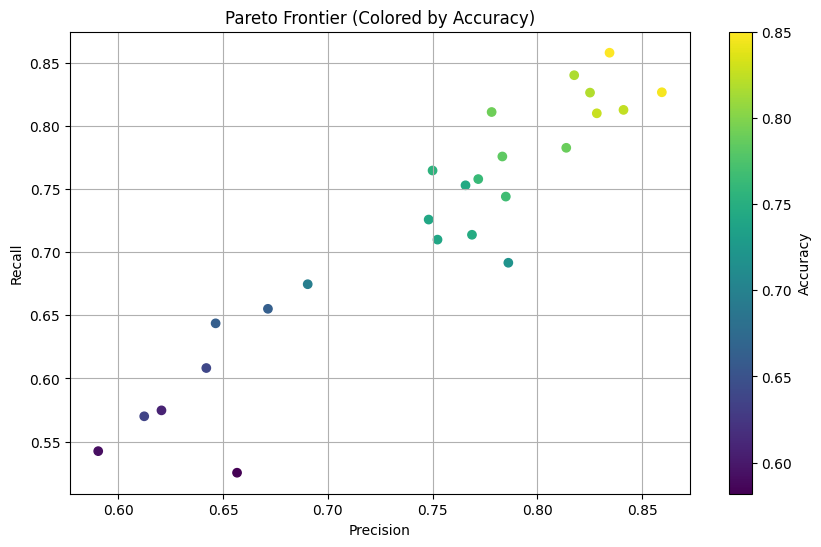

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from sklearn.metrics import precision_score, recall_score, accuracy_score
import optuna
import numpy as np
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Dataset path
dataset_path = r"C:\Users\Valmik Belgaonkar\.cache\kagglehub\datasets\sartajbhuvaji\brain-tumor-classification-mri\versions\2"

# Class names and label encoding
CLASS_NAMES = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
CLASS_TO_LABEL = {name: idx for idx, name in enumerate(CLASS_NAMES)}

# Dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, split="Training", transform=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.split_dir = os.path.join(root_dir, split)

        for class_name in CLASS_NAMES:
            class_dir = os.path.join(self.split_dir, class_name)
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(class_dir, img_file)
                    self.images.append(img_path)
                    self.labels.append(CLASS_TO_LABEL[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        image = image.resize((128, 128))
        image = transforms.ToTensor()(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

# Model definition
class TumorNet(nn.Module):
    def __init__(self, hidden_dim):
        super(TumorNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_dim * 2 * 32 * 32, 4),
        )

    def forward(self, x):
        enc = self.encoder(x)
        cls = self.classifier(enc)
        return cls

# Metrics
def compute_metrics(outputs, labels):
    outputs = outputs.argmax(dim=1).cpu().numpy()
    labels = labels.cpu().numpy()

    precision = precision_score(labels, outputs, average='macro')
    recall = recall_score(labels, outputs, average='macro')
    accuracy = accuracy_score(labels, outputs)
    bias = abs(np.mean(outputs) - np.mean(labels))

    return precision, recall, bias, accuracy

# Optuna objective
def objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [8, 16, 32])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

    model = TumorNet(hidden_dim).to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    cls_loss_fn = nn.CrossEntropyLoss()

    transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    full_dataset = BrainTumorDataset(dataset_path, split="Training", transform=transform)

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    model.train()
    for epoch in range(3):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            cls_out = model(x)
            loss = cls_loss_fn(cls_out, y)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    all_cls = []
    all_labels = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            cls_out = model(x)
            all_cls.append(cls_out)
            all_labels.append(y)

    preds = torch.cat(all_cls)
    labels = torch.cat(all_labels)

    precision, recall, bias, acc = compute_metrics(preds, labels)

    return -precision, -recall, bias, -acc

# Run Optuna
study = optuna.create_study(
    directions=["minimize", "minimize", "minimize", "minimize"]
)
study.optimize(objective, n_trials=25)

# Visualize Pareto frontier (FIXED PART)
prec = [-trial.values[0] for trial in study.trials if trial.values is not None]
rec = [-trial.values[1] for trial in study.trials if trial.values is not None]
bias = [trial.values[2] for trial in study.trials if trial.values is not None]
acc = [-trial.values[3] for trial in study.trials if trial.values is not None]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(prec, rec, c=acc, cmap='viridis')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Pareto Frontier (Colored by Accuracy)')
plt.colorbar(scatter, label='Accuracy')
plt.grid(True)
plt.show()

Pareto frontier is now plotted. Only precision and recall are getting considered to check Pareto optimal points (dominating or not).

c:\Users\Valmik Belgaonkar\OneDrive\Desktop\MOO-Brain-Tumor-Classification\mooenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-19 00:32:13,171] A new study created in memory with name: no-name-ea894864-f4d2-4fa2-a683-411645e7bbf9
[I 2025-04-19 00:33:24,169] Trial 0 finished with values: [-0.8035727093419401, -0.7982429058223273, 0.11672473867595823, -0.8031358885017421] and parameters: {'hidden_dim': 16, 'lr': 0.0005583251820132158, 'batch_size': 16}.
[I 2025-04-19 00:34:44,269] Trial 1 finished with values: [-0.8458893026907733, -0.8246425660614937, 0.1254355400696865, -0.8275261324041812] and parameters: {'hidden_dim': 32, 'lr': 0.0007825422139637979, 'batch_size': 8}.
[I 2025-04-19 00:36:03,191] Trial 2 finished with values: [-0.8166595499988614, -0.827696070596176, 0.024390243902438824, -0.822299

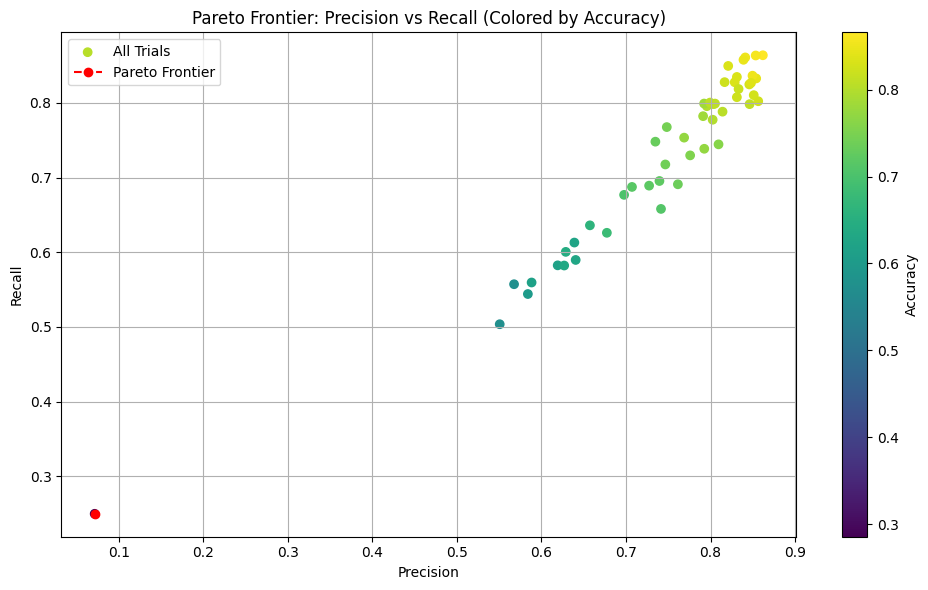

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from sklearn.metrics import precision_score, recall_score, accuracy_score
import optuna
import numpy as np
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Dataset path
dataset_path = r"C:\Users\Valmik Belgaonkar\.cache\kagglehub\datasets\sartajbhuvaji\brain-tumor-classification-mri\versions\2"

# Class names and label encoding
CLASS_NAMES = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
CLASS_TO_LABEL = {name: idx for idx, name in enumerate(CLASS_NAMES)}

# Dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, split="Training", transform=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.split_dir = os.path.join(root_dir, split)

        for class_name in CLASS_NAMES:
            class_dir = os.path.join(self.split_dir, class_name)
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(class_dir, img_file)
                    self.images.append(img_path)
                    self.labels.append(CLASS_TO_LABEL[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        image = image.resize((128, 128))
        image = transforms.ToTensor()(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

# Model definition
class TumorNet(nn.Module):
    def __init__(self, hidden_dim):
        super(TumorNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_dim * 2 * 32 * 32, 4),
        )

    def forward(self, x):
        enc = self.encoder(x)
        cls = self.classifier(enc)
        return cls

# Metrics
def compute_metrics(outputs, labels):
    outputs = outputs.argmax(dim=1).cpu().numpy()
    labels = labels.cpu().numpy()

    precision = precision_score(labels, outputs, average='macro')
    recall = recall_score(labels, outputs, average='macro')
    accuracy = accuracy_score(labels, outputs)
    bias = abs(np.mean(outputs) - np.mean(labels))

    return precision, recall, bias, accuracy

# Optuna objective
def objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [8, 16, 32])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

    model = TumorNet(hidden_dim).to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    cls_loss_fn = nn.CrossEntropyLoss()

    transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    full_dataset = BrainTumorDataset(dataset_path, split="Training", transform=transform)

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    model.train()
    for epoch in range(3):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            cls_out = model(x)
            loss = cls_loss_fn(cls_out, y)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    all_cls = []
    all_labels = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            cls_out = model(x)
            all_cls.append(cls_out)
            all_labels.append(y)

    preds = torch.cat(all_cls)
    labels = torch.cat(all_labels)

    precision, recall, bias, acc = compute_metrics(preds, labels)

    return -precision, -recall, bias, -acc

# Run Optuna
study = optuna.create_study(
    directions=["minimize", "minimize", "minimize", "minimize"]
)
study.optimize(objective, n_trials=50)

# Helper to find Pareto frontier
def get_pareto_frontier(points):
    pareto_points = []
    for i, point in enumerate(points):
        dominated = False
        for j, other in enumerate(points):
            if all(o <= p for o, p in zip(other, point)) and any(o < p for o, p in zip(other, point)):
                dominated = True
                break
        if not dominated:
            pareto_points.append(point)
    return pareto_points

# Extract metrics for plotting
prec = [-trial.values[0] for trial in study.trials if trial.values is not None]
rec = [-trial.values[1] for trial in study.trials if trial.values is not None]
bias = [trial.values[2] for trial in study.trials if trial.values is not None]
acc = [-trial.values[3] for trial in study.trials if trial.values is not None]

points = list(zip(prec, rec))
pareto = get_pareto_frontier(points)

# Plot precision vs recall, colored by accuracy
plt.figure(figsize=(10, 6))
scatter = plt.scatter(prec, rec, c=acc, cmap='viridis', label='All Trials')
pareto_x, pareto_y = zip(*pareto)
plt.plot(pareto_x, pareto_y, 'r--', marker='o', label='Pareto Frontier')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Pareto Frontier: Precision vs Recall (Colored by Accuracy)')
plt.colorbar(scatter, label='Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Removed plotting section. Added .csv files generation. Now, Pareto optimality is checked using all 4 parameters.

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from sklearn.metrics import precision_score, recall_score, accuracy_score
import optuna
import numpy as np
import pandas as pd
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Dataset path
dataset_path = r"C:\Users\Valmik Belgaonkar\.cache\kagglehub\datasets\sartajbhuvaji\brain-tumor-classification-mri\versions\2"

# Class names and label encoding
CLASS_NAMES = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
CLASS_TO_LABEL = {name: idx for idx, name in enumerate(CLASS_NAMES)}

# Dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, split="Training", transform=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.split_dir = os.path.join(root_dir, split)

        for class_name in CLASS_NAMES:
            class_dir = os.path.join(self.split_dir, class_name)
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(class_dir, img_file)
                    self.images.append(img_path)
                    self.labels.append(CLASS_TO_LABEL[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        image = image.resize((128, 128))
        image = transforms.ToTensor()(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

# Model definition
class TumorNet(nn.Module):
    def __init__(self, hidden_dim):
        super(TumorNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_dim * 2 * 32 * 32, 4),
        )

    def forward(self, x):
        enc = self.encoder(x)
        cls = self.classifier(enc)
        return cls

# Metrics
def compute_metrics(outputs, labels):
    outputs = outputs.argmax(dim=1).cpu().numpy()
    labels = labels.cpu().numpy()

    precision = precision_score(labels, outputs, average='macro', zero_division=0)
    recall = recall_score(labels, outputs, average='macro', zero_division=0)
    accuracy = accuracy_score(labels, outputs)
    bias = abs(np.mean(outputs) - np.mean(labels))

    return precision, recall, bias, accuracy

# Optuna objective
def objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [8, 16, 32])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

    model = TumorNet(hidden_dim).to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    cls_loss_fn = nn.CrossEntropyLoss()

    transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    full_dataset = BrainTumorDataset(dataset_path, split="Training", transform=transform)

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    model.train()
    for epoch in range(3):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            cls_out = model(x)
            loss = cls_loss_fn(cls_out, y)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    all_cls = []
    all_labels = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            cls_out = model(x)
            all_cls.append(cls_out)
            all_labels.append(y)

    preds = torch.cat(all_cls)
    labels = torch.cat(all_labels)

    precision, recall, bias, acc = compute_metrics(preds, labels)

    return -precision, -recall, bias, -acc

# Run Optuna
study = optuna.create_study(
    directions=["minimize", "minimize", "minimize", "minimize"]
)
study.optimize(objective, n_trials=200)

# Convert study trials to DataFrame
results = []
for trial in study.trials:
    if trial.values is not None:
        precision = -trial.values[0]
        recall = -trial.values[1]
        bias = trial.values[2]
        accuracy = -trial.values[3]
        results.append({
            "trial": trial.number,
            "precision": precision,
            "recall": recall,
            "bias": bias,
            "accuracy": accuracy
        })

df_all = pd.DataFrame(results)

# Save all points to CSV
df_all.to_csv("all_points.csv", index=False)

# Pareto frontier with all 4 objectives
def dominates(p1, p2):
    """Returns True if p1 dominates p2"""
    better_or_equal = (
        p1["precision"] >= p2["precision"] and
        p1["recall"] >= p2["recall"] and
        p1["accuracy"] >= p2["accuracy"] and
        p1["bias"] <= p2["bias"]
    )
    strictly_better = (
        p1["precision"] > p2["precision"] or
        p1["recall"] > p2["recall"] or
        p1["accuracy"] > p2["accuracy"] or
        p1["bias"] < p2["bias"]
    )
    return better_or_equal and strictly_better

def get_full_pareto_frontier(points):
    pareto_front = []
    for i, p1 in enumerate(points):
        is_dominated = False
        for j, p2 in enumerate(points):
            if i != j and dominates(p2, p1):
                is_dominated = True
                break
        if not is_dominated:
            pareto_front.append(p1)
    return pareto_front

pareto_front = get_full_pareto_frontier(results)
df_pareto = pd.DataFrame(pareto_front)

# Save Pareto points to CSV
df_pareto.to_csv("pareto_points.csv", index=False)

print("Saved 'all_points.csv' and 'pareto_points.csv'.")

c:\Users\Valmik Belgaonkar\OneDrive\Desktop\MOO-Brain-Tumor-Classification\mooenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-19 15:10:42,476] A new study created in memory with name: no-name-9c94fcd8-fe75-4d1b-bc04-28111a6dc7de
[I 2025-04-19 15:12:56,185] Trial 0 finished with values: [-0.7530140061224934, -0.6632612940204607, 0.2247386759581882, -0.705574912891986] and parameters: {'hidden_dim': 16, 'lr': 0.00012828950544398248, 'batch_size': 32}.
[I 2025-04-19 15:15:12,655] Trial 1 finished with values: [-0.8609306504419039, -0.8489482501861505, 0.020905923344947785, -0.8571428571428571] and parameters: {'hidden_dim': 16, 'lr': 0.0008660004278459646, 'batch_size': 8}.
[I 2025-04-19 15:20:45,748] Trial 2 finished with values: [-0.06968641114982578, -0.25, 1.4181184668989546, -0.2787456445993031] a

Saved 'all_points.csv' and 'pareto_points.csv'.
